# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 6</span>


## Exercise 06.1

Complete the NSL_simulator code to simulate a 1D Ising model with the Gibbs sampling algorithm (the Metropolis algorithm is already implemented) to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$. Verify the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

## The Ising 1D Model:
In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$:


## Metropolis Algorithm

Metropolis Algoritm is just explained in  `Lezione_05`, to see the application, read the next paragraph.

## Gibbs Algorithmn
The Gibbs sampling,also known as the heath-bath algorithm,is conceptually the simplest of the Markov chain sampling methods. It is widely applicable to problems where the variables take on values from a small finite set, or have conditional probability distributions of a form that can easily be sampled from. So it could be considered as a Metropolis Algorithm where the pass porpose is always accepted.

In particular the aim of this exercise is to simulate the 1D Ising model sampled with the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$; where the Hamiltonian H is: 
$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

In general, the Gibbs sampling process works as follows: given a system configuration defined by certain parameters, a variation of the system is proposed by sampling one component at a time from the conditional distribution of that component, while keeping the others fixed. This generates a sequence of steps where each change is based on the conditional probability $T_{k}$ of a transition occurring, given the current configuration. In this way, a Markov chain is generated, where the transition probabilities between states are determined by the conditional distributions:

$$
T_{k} (x|y) = \rho_{1|n -1}(x_k{y_i : i ≠ k}) \cdot \prod_{\substack{i \\ i \neq k}} \delta(x_i - y_i)
$$
con k = 1,...n


### Gibbs algorithm applicated to exercise:
In this case, the problem starts with a configuration, an array of `50 particles`, where the only parameter of interest is the spin. In that case the program provides a class called `particle` with the property of it like position and spin in this particolar case. The algorithm aims to propose a probability of flipping the spin for each particle by calculating the conditional probability using the Boltzmann distribution, written as follows:
$$
\rho(\{ s_i \}) = \exp(-\beta H)/Z.
$$
This is because the system is set in a canonical ensemble, where the number of particles and temperature are fixed, and only energy can be exchanged with the external environment.

The probability of flipping spin $\rho(s_k =\pm 1 )$ is given by the equation:
$$ 
p(s_{k}=\pm 1) = \frac{1}{1 + \exp{[\mp \beta \Delta E]}} 
$$

where $\Delta E$ is the different of energy between the porposed state and the actual one.

In the programm the step is porposed by a method called `move()` where the step is porposed by `Metropolis sampling, metro()` or `Gibbs sampling, Gibbs()` depending on the type of simulation is chosen.

````cpp
    void System :: move(int i){ // Propose a MC move for particle i
      if(_sim_type == 3){ //Gibbs sampler for Ising
    
        if (_rnd.Rannyu() <= Gibbs(i)){
           _particle(i).setspin(1); 
           _naccepted++;
        } else{
           _particle(i).setspin(-1);
           _naccepted++;
        }
      }            
      else {                  // Ising 1D
          if(this->metro(i)){     //Metropolis (M(RT)^2) acceptance evaluation for a spin flip involving spin i
            _particle(i).flip();  //If accepted, the spin i is flipped
            _naccepted++;
          }
        }
      }
      return;
    }
````
- Metropolis moved porpose: as explained in exercise `Lezione_5` for the Metropolis the step must be accepted, as follow:

````cpp    
    bool System :: metro(int i){ // Metropolis algorithm
      bool decision = false;
      double delta_E, acceptance;
      if(_sim_type == 1) delta_E = this->Boltzmann(i,true) - this->Boltzmann(i,false);
      else delta_E = 2.0 * _particle(i).getspin() * 
                     ( _J * (_particle(this->pbc(i-1)).getspin() + _particle(this->pbc(i+1)).getspin() ) + _H );
      acceptance = exp(-_beta*delta_E);
      if(_rnd.Rannyu() < acceptance ) decision = true; //Metropolis acceptance step
      return decision;
    }
````
- Gibbs moved porpose:
````cpp   
    double System :: Gibbs(int i){
      //conditional probability: (always calculated in case spin porposed = +1)
      double prob_cond = 0.0;
       prob_cond = (1./(1+exp(- 2. *_beta *( _J* (_particle(this->pbc(i-1)).getspin() + _particle(this->pbc(i+1)).getspin() )+_H))));
      
       return prob_cond;
    }

````

It is important to notice that the exercise fixes certain boundary conditions with the function `pcb()`, which allows the first particle of the array to be connected with the last one.






## Information about the code:
The instruction to compile the the code are written in the `Read.me`
Like the exercise `Lezione_4` the code is structurally the same. The program is put in a directory `SOURCE`, all the data measured are stored in the directory `OUTPUT/ISING/EQUILIBRATION` and `OUTPUT/ISING` 
In the directory `INPUT/ISING` there a two file `input_equilitbration.dat` and `input.dat` where there are the physical informations of the system prepared for the simulation, an example is put below:


| Parameter       | Value |
|-----------------| ------|
| SIMULATION_TYPE |  2/3	1.0	 0.02    |
| RESTART         | 0/1     |
| TEMP            | 0.5  |
| NPART           | 50   |
| RHO             | 1.0  |
| R_CUT           | 0.0   |
| DELTA           | 0.0|
| NBLOCKS         | 500   |
| NSTEPS          | 2000000  |
| ENDINPUT        |       |

As it is possible to see, there are some differences and improvements to note from the `Lezione_4` exercise code:

- Use of `SIMULATION_TYPE: 2` is for Metropolis sampling and `3` for Gibbs sampling; the other two values represent, respectively, the interaction energy `J` and the external field `H`.
- Usage of `RESTART`: In this exercise, I implemented the `RESTART` command function. As in the `Lezione_4` exercise, I divided the process into two phases: `equilibration` and `evolution`. If `RESTART = 0`, the code sets all spins up, while if `RESTART = 1`, the simulation uses the last configuration saved in the file OUTPUT/ISING/configuration.spin.
- For equilibration, I used `500 blocks`, and for evolution, `50 blocks`. At the end of each measurement, I used a function called `modify_temp_input` to set a different temperature and rerun the measurements. The program is designed to perform measurements over a temperature range between $[0.5-2.]$. Each time the system completes a measurement cycle, the program registers the final spin configuration in config.spin, which is then used in the next measurement cycle.


## Equilibration

Since we are studying the evolution of macroscopic quantities such as internal energy, heat capacity, magnetic susceptibility, and magnetization, it's important to ensure that the system reaches a stationary state before starting to collect data. This is necessary because the system must explore its configuration space and reach equilibrium for the macroscopic quantities to be reliable. We also know that at high temperatures, the system is disordered, causing magnetization to approach zero, while at low temperatures, the system tends to become magnetized. The equilibration time depends on the temperature. For high temperatures, it is appropriate to choose a random initial spin configuration, whereas for low temperatures, a magnetized initial configuration is more suitable.

I chose to equilibrate the system at `T = 0.5` with an initial spin configuration where all spins are up. Below, I present graphs showing the equilibration of all macroscopic quantities, comparing Metropolis and Gibbs sampling. Equilibration is considered reached when these quantities become constant.

For magnetization, I performed the equilibration with an external field `h = 0.02`, as required by the exercise. Equilibration was achieved in `500 blocks`.



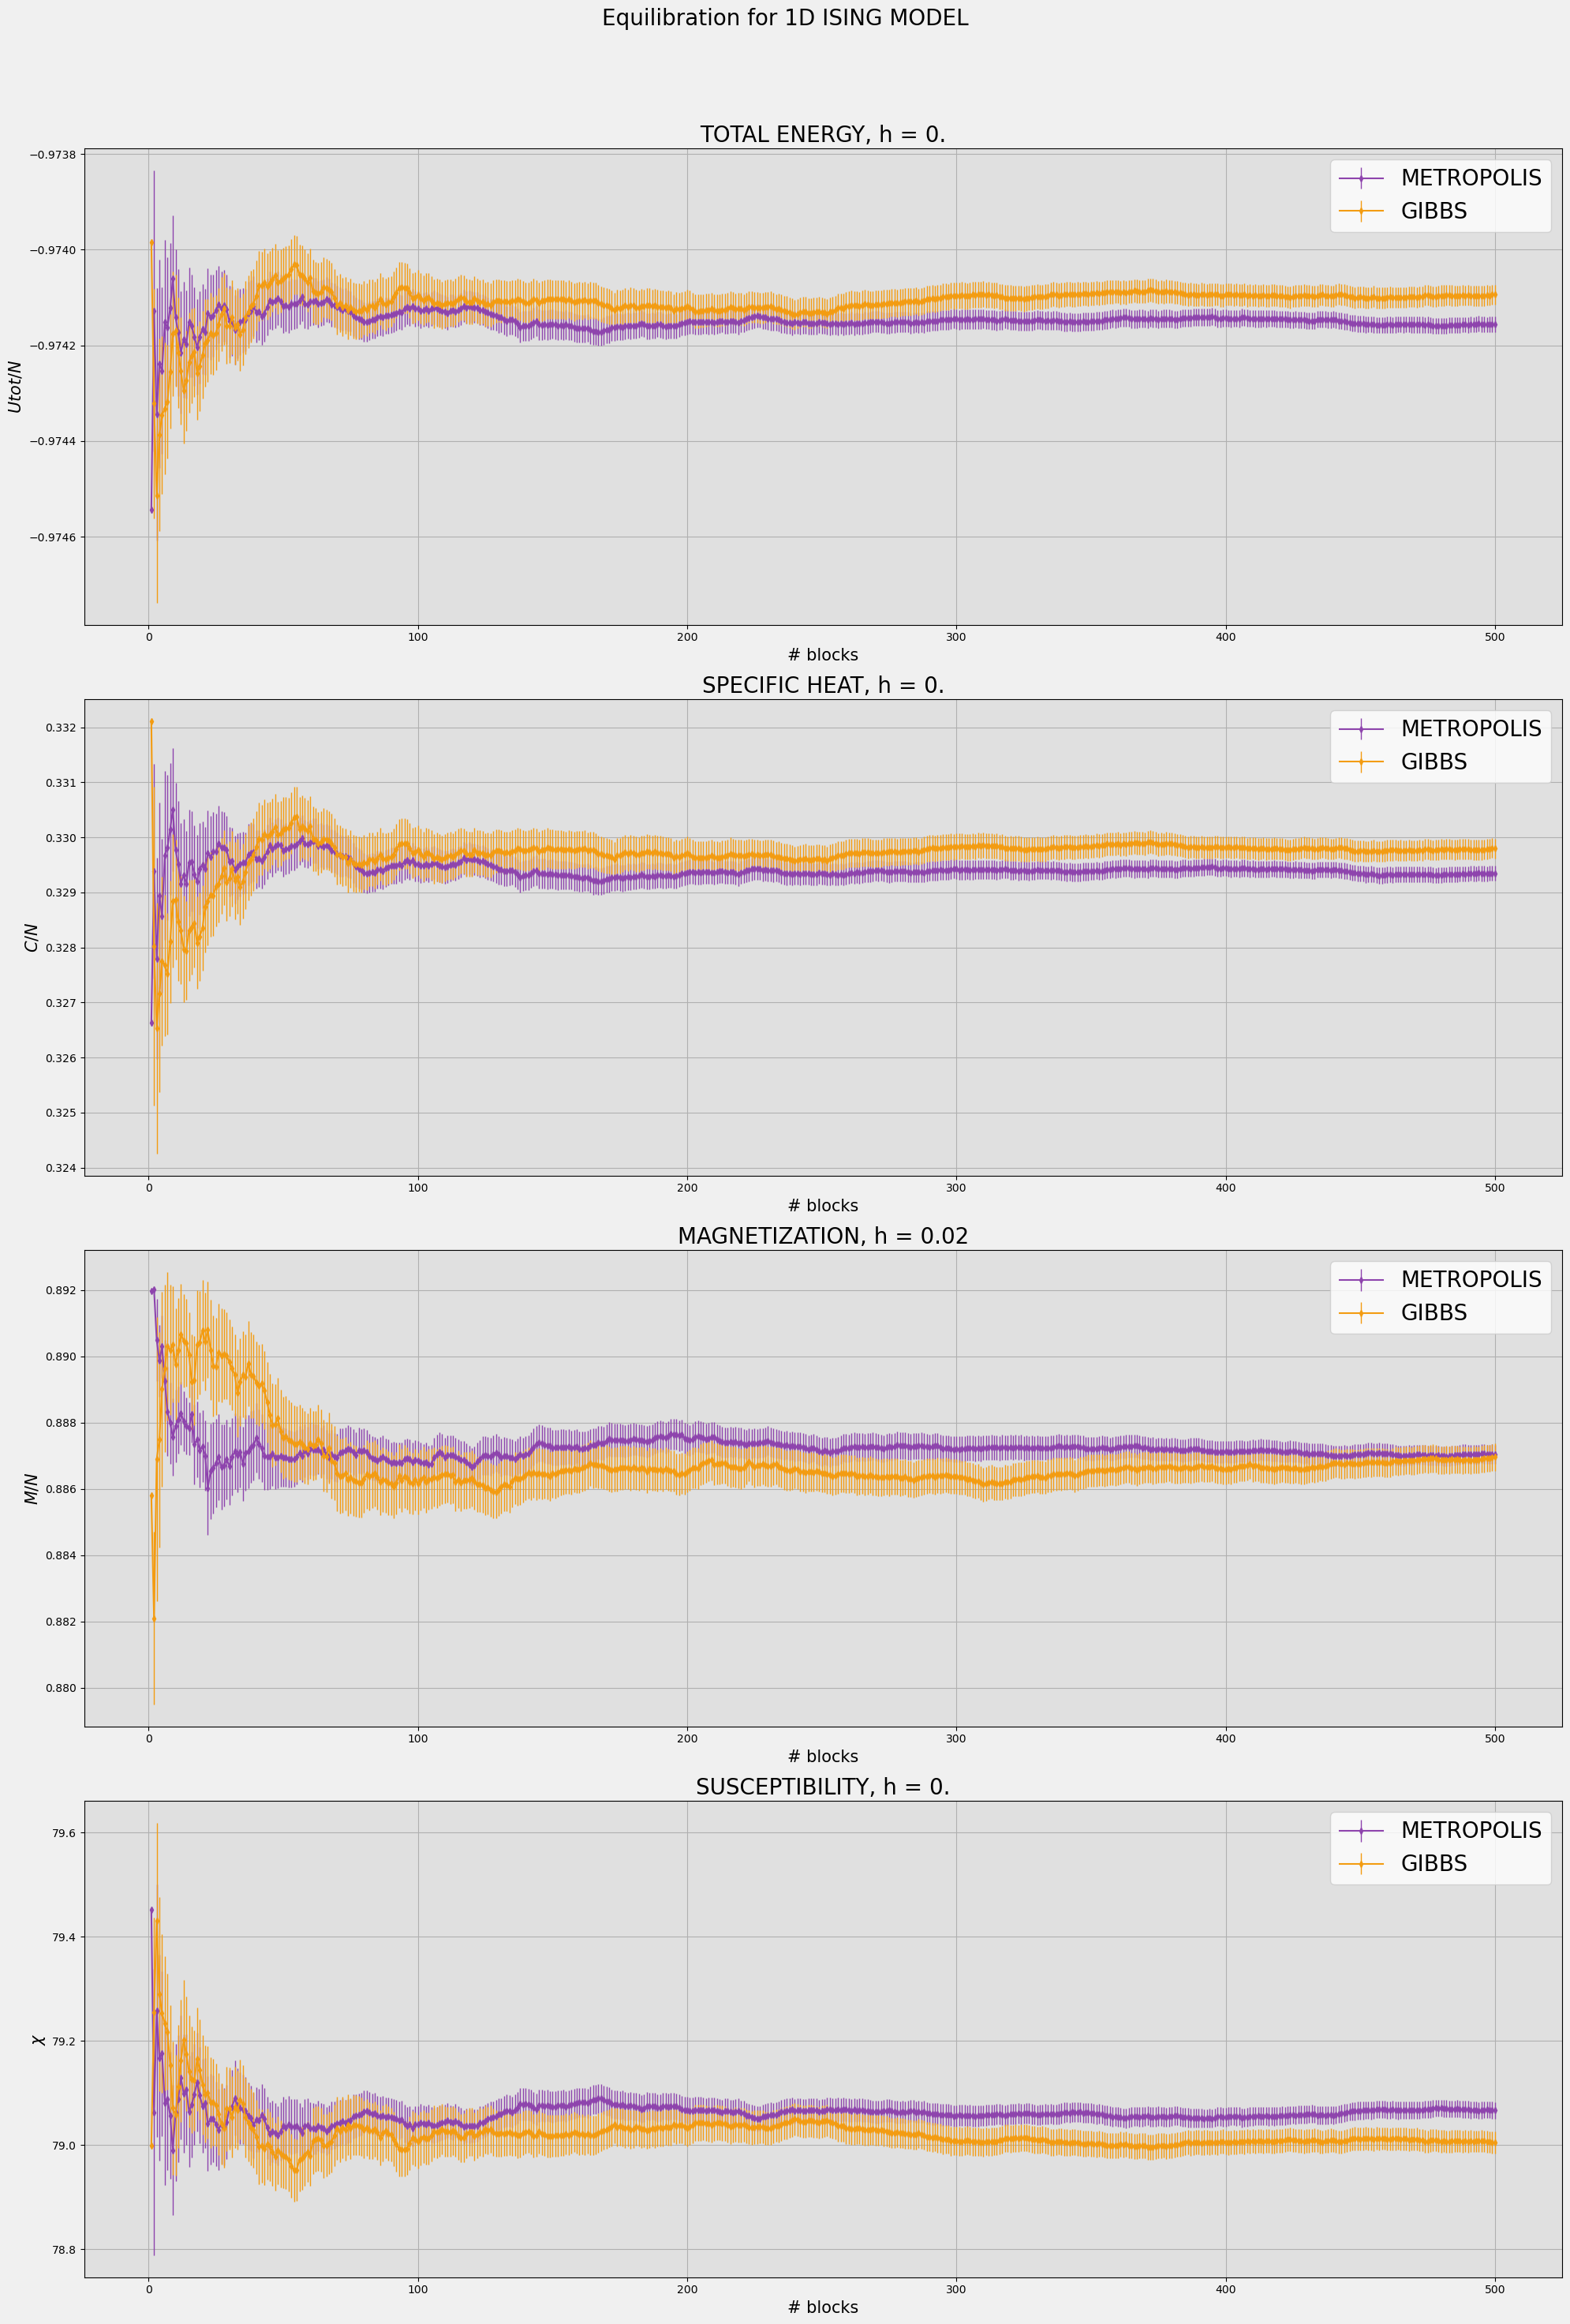

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specifiche delle colonne del file
colspecs = [(0, 12), (12, 24), (24, 36), (36, 48)]

phases = ['METROPOLIS', 'GIBBS']
energies = ['total_energy', 'cv', 'magnet_0.02_', 'chi']
titles = ['TOTAL ENERGY, h = 0.', 'SPECIFIC HEAT, h = 0.', 'MAGNETIZATION, h = 0.02', 'SUSCEPTIBILITY, h = 0.']
y_labels = ['$U{tot}/N$', '$C/N$', '$M/N$', r'$\chi$']

# Configura la griglia di sottotrame

fig, axs = plt.subplots(4, 1, figsize=(20, 30))  # Crea una griglia di 1x4
fig.suptitle('Equilibration for 1D ISING MODEL', fontsize=20)  # Titolo principale


# Definisci i colori fissi per le fasi
phase_colors = {'METROPOLIS': '#8e44ad', 'GIBBS': '#f39c12'}  # Viola e giallo scuro

# Ciclo esterno per le fasi
for phase in phases:
    # Ciclo interno per le energie
    for idx, energy in enumerate(energies):
        path = f'NSL_SIMULATOR/OUTPUT/ISING/EQUILIBRATION/{phase}_{energy}.dat'
        
        df = pd.read_fwf(path, colspecs=colspecs, header=None, skiprows=1)
        df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']

        # Assegna il colore in base alla fase
        color = phase_colors[phase]

        axs[idx].errorbar(df['blk'], df['sum_average_per_blk'], yerr=df['error'],
                          label=f'{phase}', color=color,
                          linestyle='-', marker='d', mfc=color, mec=color, ms=4, elinewidth=1)

        axs[idx].set_title(titles[idx], fontsize=20)
        axs[idx].set_xlabel('# blocks', fontsize=15)
        axs[idx].set_ylabel(y_labels[idx], fontsize=15)
        axs[idx].grid(True)

        # Imposta lo sfondo del grafico su grigio chiaro
        axs[idx].set_facecolor('#e0e0e0')

        axs[idx].legend(fontsize=20)

# Imposta lo sfondo della figura su un grigio ancora più chiaro
fig.patch.set_facecolor('#f0f0f0')

# Aggiustare il layout per evitare sovrapposizioni
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In the above graphics is possible to note the equilibration reached in `500 blocks`seeing that the macroscopic quantities are costant.

## Measure of macroscopic quantities
- <span style="color:red">Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties</span> obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with <span style="color:blue">both sampling methods, Metropolis and Gibbs</span>.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

Below are reported the grapichs of this quanties comparing the theorical resolution, giving by the exercise and the two method of sampling




- the **Internal Energy** per spin (with $h=0$ ($h$ is external field)):

$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

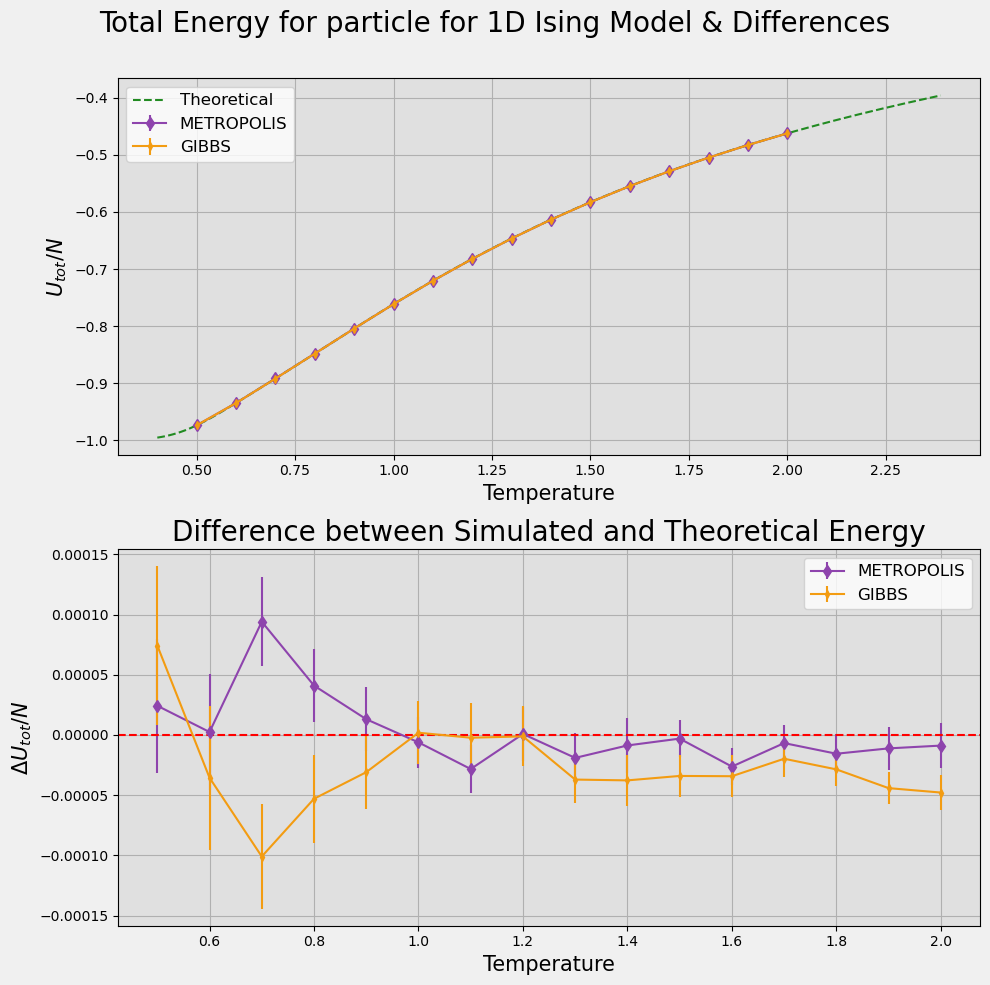

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dati teorici
T = np.arange(0.4, 2.4, 0.01)  # Più punti teorici con passo 0.01
beta = 1 / T
J = 1.0
Ns = 50
th = np.tanh(J / T)
thN = th**Ns
ch = 1 / th
e = -J * (th + ch * thN) / (1 + thN)  # Valori teorici di energia

# Phases e energies per i file di output
phases = ['METROPOLIS', 'GIBBS']
energies = ['total_energy']
titles = [' ']
y_labels = [r'$U_{tot}/N$']

# Configura la griglia di sottotrame per due grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Due grafici in verticale
fig.suptitle('Total Energy for particle for 1D Ising Model & Differences', fontsize=20)
temperatures = np.arange(0.5, 2.1, 0.1)  # Temperature della simulazione

# Colori per le fasi
phase_colors = {'METROPOLIS': '#8e44ad', 'GIBBS': '#f39c12'}

# Trova gli indici delle temperature simulate in T
mask = np.isin(np.round(T, decimals=2), np.round(temperatures, decimals=2))  # Trova le temperature comuni
T_common = T[mask]  # Temperature teoriche corrispondenti a quelle simulate
e_common = e[mask]  # Energia teorica corrispondente

# Traccia il grafico teorico nel primo subplot
ax1.plot(T, e, label='Theoretical', color='forestgreen', linestyle='--', marker=' ')

# Ciclo esterno per le fasi (METROPOLIS, GIBBS)
for phase in phases:
    # Prepara una lista per contenere i risultati delle simulazioni e le incertezze
    results = {energy: [] for energy in energies}
    uncertainties = {energy: [] for energy in energies}

    # Ciclo per ogni temperatura simulata
    for temp in temperatures:
        temp_str = f"{temp:.2f}"  # Formatta la temperatura

        for idx, energy in enumerate(energies):
            # Percorso del file
            path = f'NSL_SIMULATOR/OUTPUT/ISING/{phase}_{energy}_{temp_str}_.dat'
            
            try:
                # Legge i dati dal file
                df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
                df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
                # Aggiunge l'ultimo valore di 'sum_average_per_blk' e 'error' ai risultati
                results[energy].append(df['sum_average_per_blk'].iloc[-1])
                uncertainties[energy].append(df['error'].iloc[-1])
            except FileNotFoundError:
                results[energy].append(np.nan)  # Se manca un file, aggiunge NaN
                uncertainties[energy].append(np.nan)  # Aggiunge NaN per l'incertezza

    # Dopo aver raccolto i dati, li tracciamo
    for idx, energy in enumerate(energies):
        color = phase_colors[phase]
        marker_size = 4 if phase == 'GIBBS' else 6
        
        # Traccia l'energia simulata con incertezze nel primo grafico
        ax1.errorbar(temperatures, results[energy], yerr=uncertainties[energy], label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

        # Calcola la differenza tra i risultati simulati e i valori teorici corrispondenti
        diff = np.array(results[energy]) - e_common
        uncertainty = np.array(uncertainties[energy])

        # Traccia le differenze nel secondo grafico con incertezze
        ax2.errorbar(temperatures, diff, yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

# Titoli e etichette per il primo grafico
ax1.set_title(titles[0], fontsize=20)
ax1.set_xlabel('Temperature', fontsize=15)
ax1.set_ylabel('$U_{tot}/N$', fontsize=15)
ax1.grid(True)
ax1.set_facecolor('#e0e0e0')  # Sfondo grigio
ax1.legend(fontsize=12)

# Titoli e etichette per il secondo grafico
ax2.set_title('Difference between Simulated and Theoretical Energy', fontsize=20)
ax2.set_xlabel('Temperature', fontsize=15)
ax2.set_ylabel('$\Delta U_{tot}/N$', fontsize=15)
ax2.grid(True)
ax2.set_facecolor('#e0e0e0')  # Sfondo grigio
ax2.legend(fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Imposta lo sfondo della figura su grigio chiaro
fig.patch.set_facecolor('#f0f0f0')

# Aggiusta il layout
plt.tight_layout()
plt.show()


- the **Heat Capacity** (with $h=0$):

$$
C(N,T) = \frac{\partial U(N,T)}{\partial T}
= \frac{\partial \beta}{\partial T}\frac{\partial U}{\partial \beta}
= -k_B\beta^2 \frac{\partial}{\partial \beta} \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z} \right] = \\
= -k_B\beta^2 \left[ -\sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \sum_{\{ s_i \}} H \exp \left( -\beta H\right)\frac{\partial Z^{-1}}{\partial \beta} \right] = \\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]\frac{1}{Z}\frac{\partial Z}{\partial \beta} \right\} =\\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} - \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]^2 \right\} =
k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)
$$

$$
\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} =\\
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

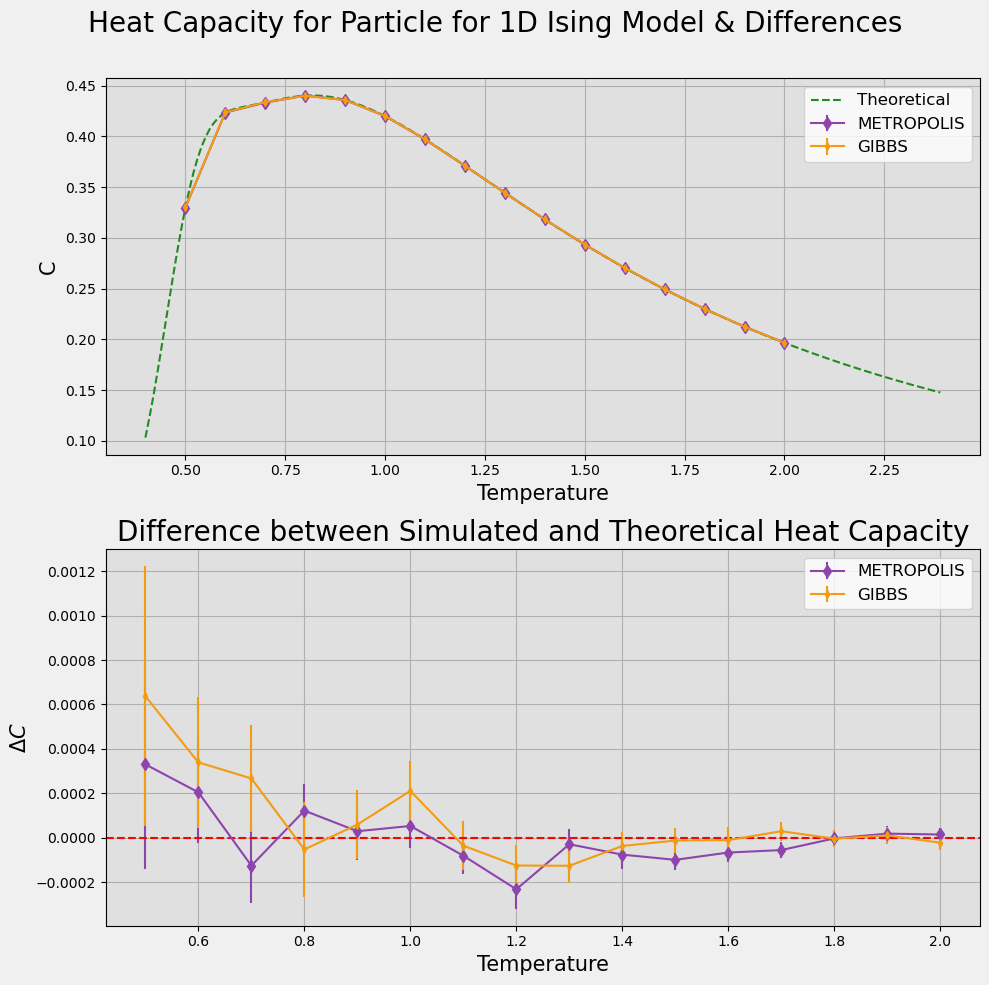

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dati teorici
T = np.arange(0.4, 2.4, 0.01)  # Più punti teorici con passo 0.01
beta = 1 / T
J = 1.0
Ns = 50
th = np.tanh(J / T)
thN = th**Ns
ch = 1 / th
C = ((beta * J)**2) * (((1 + thN + (Ns - 1) * (th**2) + (Ns - 1) * (ch**2) * thN) / (1 + thN)) - Ns * ((th + ch * thN) / (1 + thN))**2)

# Phases e energies per i file di output
phases = ['METROPOLIS', 'GIBBS']
energies = ['cv']
titles = [' ']
y_labels = [r'$\chi$']

# Configura la griglia di sottotrame
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Due grafici in verticale
fig.suptitle('Heat Capacity for Particle for 1D Ising Model & Differences', fontsize=20)
temperatures = np.arange(0.5, 2.1, 0.1)  # Temperature della simulazione

# Colori per le fasi
phase_colors = {'METROPOLIS': '#8e44ad', 'GIBBS': '#f39c12'}

# Trova gli indici delle temperature simulate in T
mask = np.isin(np.round(T, decimals=2), np.round(temperatures, decimals=2))  # Trova le temperature comuni
T_common = T[mask]  # Temperature teoriche corrispondenti a quelle simulate
C_common = C[mask]  # Capacità termica teorica corrispondente

# Traccia il grafico teorico
ax1.plot(T, C, label='Theoretical', color='forestgreen', linestyle='--', marker=' ')

# Ciclo esterno per le fasi (METROPOLIS, GIBBS)
for phase in phases:
    # Prepara una lista per contenere i risultati delle simulazioni e le incertezze
    results = {energy: [] for energy in energies}
    uncertainties = {energy: [] for energy in energies}

    # Ciclo per ogni temperatura simulata
    for temp in temperatures:
        temp_str = f"{temp:.2f}"  # Formatta la temperatura

        for idx, energy in enumerate(energies):
            # Percorso del file
            path = f'NSL_SIMULATOR/OUTPUT/ISING/{phase}_{energy}_{temp_str}_.dat'
            
            try:
                # Legge i dati dal file
                df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
                df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
                # Aggiunge l'ultimo valore di 'sum_average_per_blk' e 'error' ai risultati
                results[energy].append(df['sum_average_per_blk'].iloc[-1])
                uncertainties[energy].append(df['error'].iloc[-1])
            except FileNotFoundError:
                results[energy].append(np.nan)  # Se manca un file, aggiunge NaN
                uncertainties[energy].append(np.nan)  # Aggiunge NaN per l'incertezza

    # Dopo aver raccolto i dati, li tracciamo
    for idx, energy in enumerate(energies):
        color = phase_colors[phase]
        marker_size = 4 if phase == 'GIBBS' else 6
        uncertainty = np.array(uncertainties[energy])
        
        # Traccia l'energia simulata con incertezze nel primo grafico
        ax1.errorbar(temperatures, results[energy], yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

        # Calcola la differenza tra i risultati simulati e i valori teorici corrispondenti
        diff = np.array(results[energy]) - C_common

        # Traccia le differenze nel secondo grafico con incertezze
        ax2.errorbar(temperatures, diff, yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

# Titoli e etichette per il primo grafico
ax1.set_title(titles[0], fontsize=20)
ax1.set_xlabel('Temperature', fontsize=15)
ax1.set_ylabel('C', fontsize=15)
ax1.grid(True)
ax1.set_facecolor('#e0e0e0')  # Sfondo grigio
ax1.legend(fontsize=12)

# Titoli e etichette per il secondo grafico
ax2.set_title('Difference between Simulated and Theoretical Heat Capacity', fontsize=20)
ax2.set_xlabel('Temperature', fontsize=15)
ax2.set_ylabel('$\Delta C$', fontsize=15)
ax2.grid(True)
ax2.set_facecolor('#e0e0e0')  # Sfondo grigio
ax2.legend(fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Imposta lo sfondo della figura su grigio chiaro
fig.patch.set_facecolor('#f0f0f0')

# Aggiustare il layout
plt.tight_layout()
plt.show()


- The **magnetization** (with $h \not= 0$):

Note that with $h=0$ the magnetization $M(N,T,h=0)=\langle \sum_{i=1,N}s_i \rangle =0$ because in 1D we cannot have a (ferromagnetic) phase transition in absence of an external magnetic field.

$$
M(N,T,h) = -\frac{\partial A}{\partial h} = k_B T \frac{\partial \ln Z}{\partial h} =
\frac{1}{\beta} \frac{1}{Z}\frac{\partial}{\partial h}\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} = \left\langle \sum_{i=1,N}s_i \right\rangle
$$

The exact formula from $M(N,T,h) = k_B T \dfrac{\partial \ln Z}{\partial h}$ is:
$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$



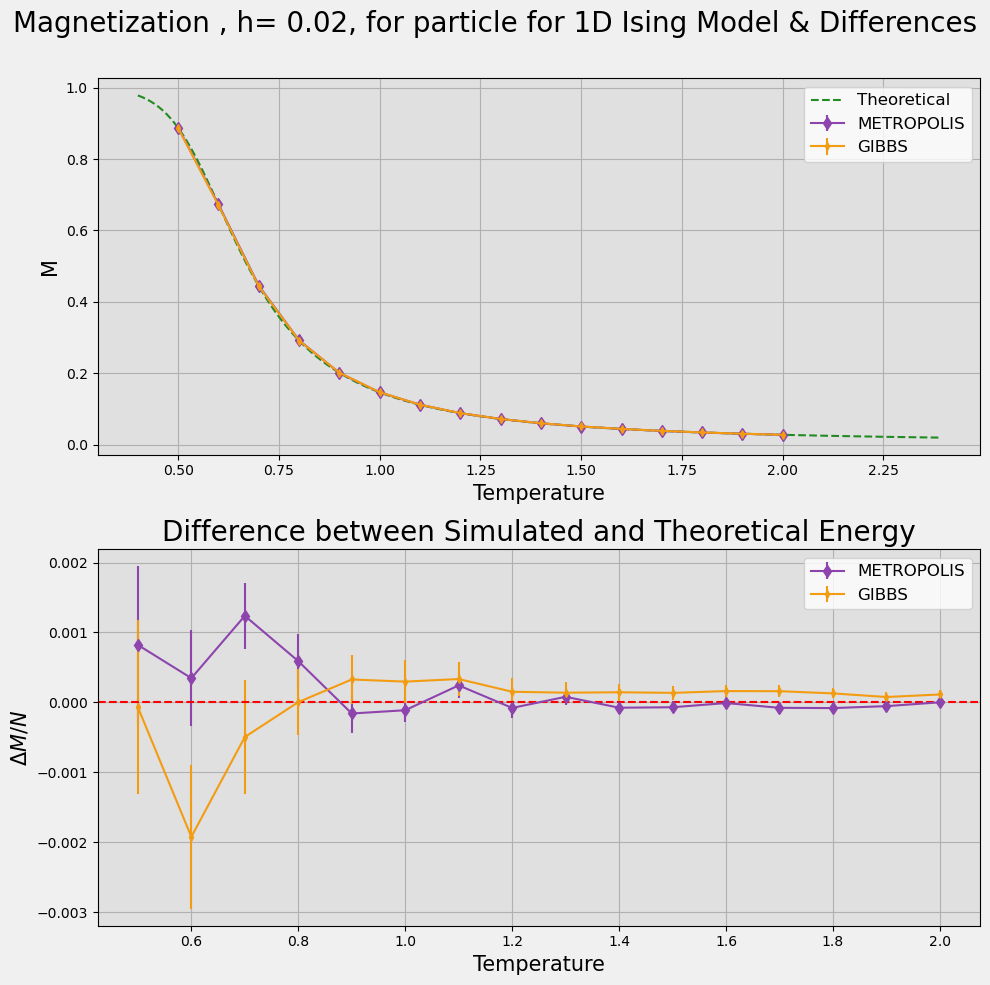

In [13]:
h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# Phases e energies per i file di output
phases = ['METROPOLIS', 'GIBBS']
energies = ['magnet']
titles = [' ']
y_labels = [r'$\chi$']


# Configura la griglia di sottotrame
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Due grafici in verticale
fig.suptitle('Magnetization , h= 0.02, for particle for 1D Ising Model & Differences', fontsize=20)
temperatures = np.arange(0.5, 2.1, 0.1)

# Colori per le fasi
phase_colors = {'METROPOLIS': '#8e44ad', 'GIBBS': '#f39c12'}

# Traccia il grafico teorico
ax1.plot(T, M, label='Theoretical', color='forestgreen', linestyle='--', marker=' ')

mask = np.isin(np.round(T, decimals=2), np.round(temperatures, decimals=2))  # Trova le temperature comuni
T_common = T[mask]  # Temperature teoriche corrispondenti a quelle simulate
M_common = M[mask]
# Ciclo esterno per le fasi (METROPOLIS, GIBBS)
for phase in phases:
    # Prepara una lista per contenere i risultati delle simulazioni
    results = {energy: [] for energy in energies}
    uncertainties = {energy: [] for energy in energies}

    # Ciclo per ogni temperatura
    for temp in temperatures:
        temp_str = f"{temp:.2f}"  # Formatta la temperatura

        for idx, energy in enumerate(energies):
            # Percorso del file
            path = f'NSL_SIMULATOR/OUTPUT/ISING/{phase}_{energy}_{temp_str}_0.02_.dat'
            
            try:
                # Legge i dati dal file
                df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
                df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
                # Aggiunge l'ultimo valore di 'sum_average_per_blk' ai risultati
                results[energy].append(df['sum_average_per_blk'].iloc[-1])
                uncertainties[energy].append(df['error'].iloc[-1])
            except FileNotFoundError:
                results[energy].append(np.nan)  # Se manca un file, aggiunge NaN
                uncertainties[energy].append(np.nan)  # Aggiunge NaN per l'incertezza

    # Dopo aver raccolto i dati, li tracciamo
    for idx, energy in enumerate(energies):
        color = phase_colors[phase]
        marker_size = 4 if phase == 'GIBBS' else 6
        uncertainty = np.array(uncertainties[energy])
        
        ax1.errorbar(temperatures, results[energy], yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)
        

        diff = np.array(results[energy]) - M_common
        ax2.errorbar(temperatures, diff, yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

# Titoli e etichette
ax1.set_title(titles[0], fontsize=20)
ax1.set_xlabel('Temperature', fontsize=15)
ax1.set_ylabel('M', fontsize=15)
ax1.grid(True)
ax1.set_facecolor('#e0e0e0')  # Sfondo grigio

ax2.set_title('Difference between Simulated and Theoretical Energy', fontsize=20)
ax2.set_xlabel('Temperature', fontsize=15)
ax2.set_ylabel('$\Delta M/N$', fontsize=15)
ax2.grid(True)
ax2.set_facecolor('#e0e0e0')  # Sfondo grigio
ax2.legend(fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)


# Aggiungi la legenda
ax1.legend(fontsize=12)

# Imposta lo sfondo della figura su grigio chiaro
fig.patch.set_facecolor('#f0f0f0')

# Aggiustare il layout
plt.tight_layout()
plt.show()


- The **magnetic susceptibility** (with $h=0$):

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} =\\
= \beta\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right]^2 \frac{\exp \left( -\beta H\right)}{Z}
-\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
\frac{1}{Z}\frac{\partial Z}{\partial h} = 
\beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] = \\
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

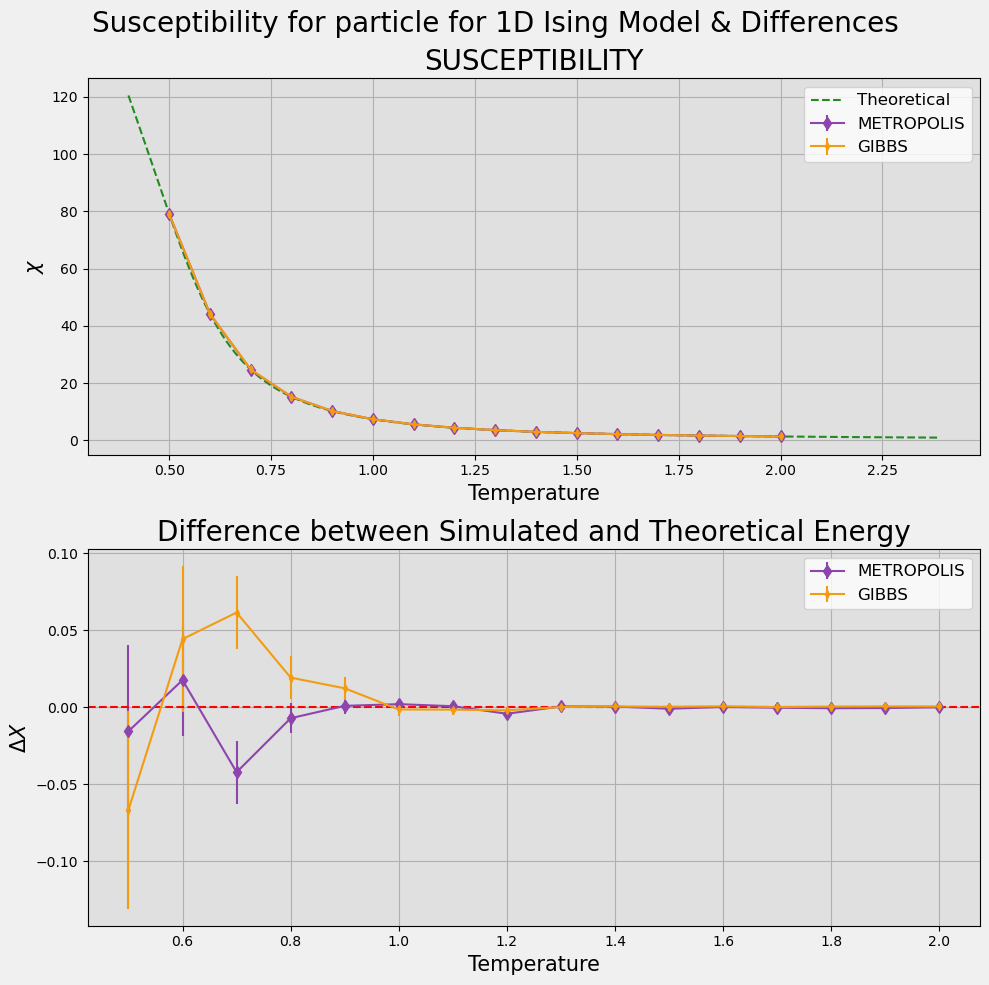

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

# Phases e energies per i file di output
phases = ['METROPOLIS', 'GIBBS']
energies = ['chi']
titles = ['SUSCEPTIBILITY']
y_labels = [r'$\chi$']


# Configura la griglia di sottotrame
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Due grafici in verticale
fig.suptitle('Susceptibility for particle for 1D Ising Model & Differences', fontsize=20)
temperatures = np.arange(0.5, 2.1, 0.1)  # Temperature della simulazione

# Colori per le fasi
phase_colors = {'METROPOLIS': '#8e44ad', 'GIBBS': '#f39c12'}

mask = np.isin(np.round(T, decimals=2), np.round(temperatures, decimals=2))  # Trova le temperature comuni
T_common = T[mask]  # Temperature teoriche corrispondenti a quelle simulate
X_common = X[mask]

# Traccia il grafico teorico
ax1.plot(T, X, label='Theoretical', color='forestgreen', linestyle='--', marker=' ')

# Ciclo esterno per le fasi (METROPOLIS, GIBBS)
for phase in phases:
    # Prepara una lista per contenere i risultati delle simulazioni
    results = {energy: [] for energy in energies}
    uncertainties = {energy: [] for energy in energies}

    # Ciclo per ogni temperatura
    for temp in temperatures:
        temp_str = f"{temp:.2f}"  # Formatta la temperatura

        for idx, energy in enumerate(energies):
            # Percorso del file
            path = f'NSL_SIMULATOR/OUTPUT/ISING/{phase}_{energy}_{temp_str}_.dat'
            
            try:
                # Legge i dati dal file
                df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
                df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
                # Aggiunge l'ultimo valore di 'sum_average_per_blk' ai risultati
                results[energy].append(df['sum_average_per_blk'].iloc[-1])
                uncertainties[energy].append(df['error'].iloc[-1])
            except FileNotFoundError:
                results[energy].append(np.nan)  # Se manca un file, aggiunge NaN
                uncertainties[energy].append(np.nan)  # Aggiunge NaN per l'incertezza

    # Dopo aver raccolto i dati, li tracciamo
    for idx, energy in enumerate(energies):
        color = phase_colors[phase]
        marker_size = 4 if phase == 'GIBBS' else 6

        uncertainty = np.array(uncertainties[energy])
        ax1.errorbar(temperatures, results[energy], yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)
        
        

        diff = np.array(results[energy]) - X_common
        ax2.errorbar(temperatures, diff, yerr=uncertainty, label=f'{phase}', color=color, linestyle='-', marker='d', ms=marker_size)

# Titoli e etichette
ax1.set_title(titles[0], fontsize=20)
ax1.set_xlabel('Temperature', fontsize=15)
ax1.set_ylabel(y_labels[0], fontsize=15)
ax1.grid(True)
ax1.set_facecolor('#e0e0e0')  # Sfondo grigio

# Aggiungi la legenda
ax1.legend(fontsize=12)

ax2.set_title('Difference between Simulated and Theoretical Energy', fontsize=20)
ax2.set_xlabel('Temperature', fontsize=15)
ax2.set_ylabel('$\Delta X$', fontsize=15)
ax2.grid(True)
ax2.set_facecolor('#e0e0e0')  # Sfondo grigio
ax2.legend(fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)


# Imposta lo sfondo della figura su grigio chiaro
fig.patch.set_facecolor('#f0f0f0')

# Aggiustare il layout
plt.tight_layout()
plt.show()


## Comment to result:

It is important to note that all the sampling methods studied closely follow the theoretical curve. To better understand this, I calculated the difference between the theoretical values and the simulated results for each method. The error bars for the first graph and for the differences are the same, as the errors are propagated in a similar manner.

Finally, the precision of the sampling methods can be summarized as follows:

- The sampling of `total energy U(N,T,h=0)/N` achieves a precision on the order of $10^{-4}$ 

- The sampling of `heat capacity C(N,T,h=0)/N` achieves a precision on the order of $10^{-4}$ 

- The sampling of `magnetization M(N,T,h=0.02)/N` achieves a precision on the order of $10^{-3}$ 

- The sampling of `susceptibility X(N,T,h=0)` achieves a precision on the order of $10^{-2}$ 
